## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

### Environment setup

In [108]:
from pystac_client import Client
import planetary_computer as pc
import os

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)
env_vars = !cat /content/.env

for var in env_vars:
    key, value = var.split(' = ')
    os.environ[key] = value

### Choose a region and time of interest

Choose a test area from the USGS data, we will repeat later for Brazil

In [135]:
import pandas as pd
import fsspec
import numpy as np
import geopandas as gpd
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image
container = 'usgs-data'

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY']}
fs = fsspec.filesystem('az', account_name=storage_options['account_name'], account_key=storage_options['account_key'])
station_url = f'az://{container}/station_metadata.csv'
station_df = pd.read_csv(station_url, storage_options=storage_options)                
fs_list = fs.ls('usgs-data/')
station_list = pd.DataFrame({'site_no':filter(None,\
                           map(lambda sub:(''.join([ele for ele in sub if ele.isnumeric()])), fs_list))}).astype('int')
filtered_station_df = station_list.merge(station_df, on='site_no')
#filter the stations to ones with data

crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(filtered_station_df,\
                       geometry=gpd.points_from_xy(filtered_station_df.Longitude, filtered_station_df.Latitude))
buffer_style = {'round':1,'flat':2,'square':3}
buffer = 0.025
gdf.geometry = gdf.geometry.buffer(buffer, cap_style = buffer_style['square'], resolution=1)


In [136]:
station = gdf.iloc[10]
url = f'az://{container}/{station.site_no:08}_data.csv' #zero pad 8 digits for site_no
df = pd.read_csv(url, storage_options=storage_options) 
df['Date-Time'] = pd.to_datetime(df['Date-Time'])

Define the aoi and time range to filter images with. 

In [137]:
coordinates =  np.dstack(station.geometry.boundary.coords.xy).tolist()
area_of_interest = {
    "type": "Polygon",
    "coordinates": coordinates,
}
start = df['Date-Time'].iloc[0].strftime('%Y-%m-%d')
end = df['Date-Time'].iloc[-1].strftime('%Y-%m-%d')
#use the date range of the data?
#time_of_interest = "2019-06-01/2019-08-01"
time_of_interest = f'{start}/{end}'

## 0.1.3. Search the collection and choose an image to render
Use pystac-client to search for Sentinel 2 L2A data

In [138]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=['sentinel-2-l2a'], 
    intersects=area_of_interest, 
    datetime=time_of_interest    
)
print(f"{search.matched()} Items found")
scene_list = sorted(search.items(), key=lambda item: item.ext.eo.cloud_cover)
#get the scence list dates and the cloud cover
cloud_list = pd.DataFrame([{'Date-Time':s.datetime.strftime('%Y-%m-%d'),\
                            'Cloud Cover':s.ext.eo.cloud_cover,\
                            'href':s.assets['visual-10m'].href} for s in scene_list])

816 Items found


Get the URL to the 10m resolution visual [Cloud Optimized GeoTIFF](https://www.cogeo.org/) image.

This HREF is a URL is the location of the asset data on Azure Blob Storage. In order to read the data, we'll need to retrieve a Shared Access Signature and supply it as a query parameter. These tokens are generated from the Planetary Computer Data Access API.

We use the planetary-computer package to "sign" our asset HREF with a generated token:

In [139]:
signed_href = pc.sign(cloud_list.iloc[0]['href'])

We can now use the HREF to read our data in any tools that can retrieve data from URLs via HTTP GET operations.

For example, here we use rasterio to render the image data over our area of interest:

## 0.1.4. Render our AOI from this image

In [140]:
with rasterio.open(signed_href) as ds:    
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

rasterio gives us data band-interleave format; transpose to pixel interleave, and downscale the image data for plotting. Given the bounds, we will select the a nxn image around our point of interest

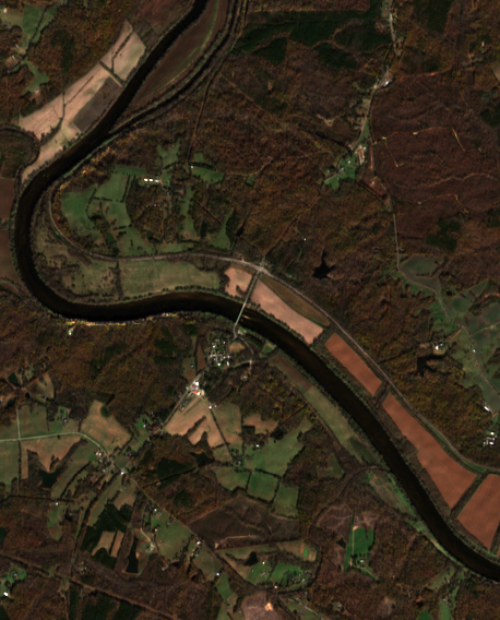

In [141]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]; h = img.size[1]; aspect = w/h
target_w = 500; target_h = (int)(target_w/aspect)
img.resize((target_w,target_h),Image.BILINEAR)